In [1]:
import numpy as np
import pandas as pd
import time
from scaling_utils import softmax, unpickle_logits, get_preds_confs, get_bins_info, ECE, MCE
from temperature_scaling import TemperatureScaling
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
import pickle

In [2]:
def model_evaluation(probs, y_true, num_bins=15):
    """
    Evaluate model using various scoring measures: Error rate, ECE, MCE, NLL

    Args:
        probs: ndarray, the output probabilities for all the classes with a shape (num_samples, classes)
        y_true: a list containing the actual class labels
        bins: how many bins are the probabilities divided into

    Return:
        (error, ece, mce, loss) respectively
    """
    # Take the maximum confidence as prediction
    preds = np.argmax(probs, axis=1)
    confs = np.max(probs, axis=1)
    
    y_true = y_true.astype(np.float32)

    accuracy = metrics.accuracy_score(y_true, preds) * 100
    error = 100 - accuracy

    # Calculate ECE and MCE
    ece = ECE(confs, preds, y_true, bin_size=1/num_bins)
    mce = MCE(confs, preds, y_true, bin_size=1/num_bins)

    print("Accuracy {:.2f}%".format(accuracy))
    print("Error rate {:.2f}%".format(error))
    print("ECE {:.3f}".format(ece))
    print("MCE {:.3f}".format(mce))

    return (error, ece, mce)


def model_calibration(logits_file, M=15):
    """
    Calibrate model scores with temperature scaling using output from logits files.

    Args:
        logits_file: pickled logits file with data in the format ((y_logits_val, y_val), (y_logits_test, y_test))
        M: number of bins

    Return:
        Calibrated results for input logits file.
    """
    bin_size = 1 / M

    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_logits(logits_file)
    
    # Convert to float format labels
    y_val = y_val.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    # Learn the temperature with validation set
    scaler = TemperatureScaling()
    scaler.fit(y_logits_val, y_val)
    #scaler.fit(y_logits_test, y_test)
    
    # Conduct model calibration with learnt temperature
    y_probs_val = scaler.predict(y_logits_val)
    y_probs_test = scaler.predict(y_logits_test)
    
    # Model performance before scaling
    print("Model performance before temperature scaling:")
    # Below metrics are printed out from model_evaluation call, so here we do not need to print them again
    error, ece, mce = model_evaluation(softmax(y_logits_test), y_test, num_bins=M)
    
    # Model performance after scaling
    print("Model performance after temperature scaling:")
    # Below metrics are printed out from model_evaluation call, so here we do not need to print them again
    error2, ece2, mce2 = model_evaluation(y_probs_test, y_test, num_bins=M)

    y_preds_val, y_confs_val = get_preds_confs(y_probs_val)
    y_preds_test, y_confs_test = get_preds_confs(y_probs_test)

    accs_val, confs_val, len_bins_val = get_bins_info(y_confs_val, y_preds_val, y_val, bin_size=bin_size)
    accs_test, confs_test, len_bins_test = get_bins_info(y_confs_test, y_preds_test, y_test, bin_size=bin_size)
    print("Elements number in each bin after calibration is", len_bins_test)
    
    return (accs_test, confs_test, len_bins_test), (accs_val, confs_val, len_bins_val)


def get_uncalibrated(logits_file, M=15):

    bin_size = 1 / M

    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_logits(logits_file)
    
    y_test = y_test.astype(np.float32)
    y_probs_test = softmax(y_logits_test)
    y_preds_test, y_confs_test = get_preds_confs(y_probs_test)

    return get_bins_info(y_confs_test, y_preds_test, y_test, bin_size=bin_size)


# Reliability diagram plotting for subplot case.
def sub_reliability_diagram(accs, confs, ax, M=10, name="Reliability Diagram", xname="", yname=""):
    accs_confs = np.column_stack([accs, confs])
    accs_confs.sort(axis=1)
    # Outputs is model accuracy
    outputs = accs_confs[:, 0]
    # Gap is actually confidences themselves
    gap = accs_confs[:, 1]

    bin_size = 1 / M
    positions = np.arange(0 + bin_size / 2, 1 + bin_size / 2, bin_size)
    
    # This is only for illustration's sake, but not the real definition of gap
    #gap = positions

    # Plot gap/confidences first, so its below everything
    gap_plot = ax.bar(positions, gap, width=bin_size, edgecolor="red", color="red",
        alpha=0.3, label="Gap", linewidth=2, zorder=2)
    # Plot accuracies
    outputs_plot = ax.bar(positions, outputs, width=bin_size, edgecolor="black", color="blue", 
        label="Outputs", zorder=3)

    # Line plot for center line
    ax.set_aspect("equal")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.legend(handles=[gap_plot, outputs_plot])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(name, fontsize=17)
    ax.set_xlabel(xname, fontsize=17, color="black")
    ax.set_ylabel(yname, fontsize=17, color="black")

    
# Draw reliability diagrams
def reliability_diagrams(logits_files, plot_names=[], M=15):

    for i, logits_file in enumerate(logits_files):
        bins_info_uncal = get_uncalibrated(logits_file, M)
        print("Elements number in each bin before calibration is", bins_info_uncal[2])

        accs_confs = []
        accs_confs.append(model_calibration(logits_file, M))

        plt.style.use("ggplot")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex="col", sharey="row")
        names = ["(Uncalibrated)", "(Temperature Scaling)"]

        # Unclibrated information
        sub_reliability_diagram(bins_info_uncal[0], bins_info_uncal[1], ax[0], M=M, 
            name="\n".join(plot_names[i].split()) + names[0], xname="Confidence")

        sub_reliability_diagram(accs_confs[0][0][0], accs_confs[0][0][1], ax[1], M=M,
            name="\n".join(plot_names[i].split()) + names[1], xname="Confidence")

        ax[0].set_ylabel("Accuracy", color="black")

        plt.show()

In [3]:
# Logit files should be kept in a list so it is easier for comparision
logit_files = ["./sample_logits.p"]

Elements number in each bin before calibration is [0, 0, 0, 7, 32, 124, 130, 119, 206, 9382]
The resulted temperature is: 2.883
Model performance before temperature scaling:
Accuracy 92.42%
Error rate 7.58%
ECE 0.055
MCE 0.323
Model performance after temperature scaling:
Accuracy 92.42%
Error rate 7.58%
ECE 0.009
MCE 0.073
Elements number in each bin after calibration is [0, 0, 21, 83, 167, 313, 315, 386, 559, 8156]


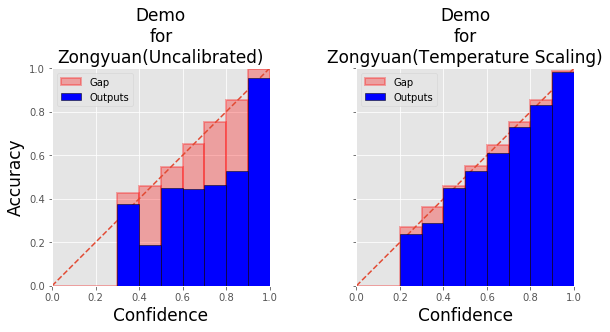

In [4]:
reliability_diagrams(logit_files, plot_names=["Demo for Zongyuan"], M=10)